# Marginalisation of $\sigma_w$

Consider the scenario where the target evolves according to the Langevin model, driven by a normal sigma-mean mixture with the mixing distribution being the $\alpha$-stable distribution.

In [155]:
import numpy as np
from datetime import datetime, timedelta

The state of the target can be represented as 2D Cartesian coordinates, $\left[x, \dot x, y, \dot y\right]^{\top}$, modelling both its position and velocity. A simple truth path is created with a sampling rate of 1 Hz.

In [156]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.models.base_driver import GaussianResidualApproxCase
from stonesoup.models.driver import AlphaStableNSMDriver 
from stonesoup.models.transition.levylinear import LevyLangevin, CombinedLinearLevyTransitionModel

# And the clock starts
start_time = datetime.now().replace(microsecond=0)

The `LevyLangevin` class creates a one-dimensional Langevin model, driven by the $\alpha$-stable NSM mixture process defined in the `AlphaStableNSMDriver` class.

\begin{equation}
d \dot{x}(t)=-\theta \dot{x}(t) d t+d W(t), \quad \theta>0
\end{equation}

where $\theta$ is the damping factor and $W(t)$ is the non-Gaussian driving process.

The noise samples $\mathbf{w}_n$ are drawn from the $\alpha$-stable distribution parameterized by the $\alpha$-stable law, $S_{\alpha}(\sigma, \beta, \mu)$.

The input parameters to `AlphaStableNSMDriver` class are the stability index $\alpha$, expected jumps per unit time $c$, conditional Gaussian mean $\mu_W$ & variance $\sigma_W^2$, and the type of residuals used for the truncated shot-noise representation, specified by `noise_case`. 

Without diving into technical details, the scaling factor $\sigma$, skewness parameter $\beta$ and location $\mu$, in the $\alpha$-stable law is a function of the conditional Gaussian parameters $\mu_W, \sigma_W^2$. In general, set $\mu_W=0$ for a symmetric target distribution $\beta=0$, or $\mu_W \neq 0$ to model biased trajectories otherwise. In addition, the size of the resulting trajectories (and jumps) can be adjusted by varying $\sigma_W^2$.

The available noise cases are:

1. No residuals, `TruncatedCase`, least expensive but drawn noise samples deviate further from target distribution.
2. `GaussianResidualApproxCase`, the most expensive but drawn noise samples closest target distribution.
3. `PartialGaussianResidualApproxCase`, a compromise between both cases (1) and (2).


For interested readers, refer to [1, 2] for more details.

Here, we initialise an $\alpha$-stable driver with the default parameters `mu_W=0, sigma_W2=1, alpha=1.4, noise_case=GaussianResidualApproxCase(), c=10`.

Then, the driver instance is injected into the Langevin model for every coordinate axes (i.e., x and y) during initialisation with parameter `damping_coeff=0.15`.

Note that we overwrite the default `mu_W` parameter in the $\alpha$-stable driver for the x-coordinate axes to bias our trajectories towards the left. This can be done by passing an additional argument `mu_W = -0.02` when injecting the driver into the Langevin model.

Finallt, the `CombinedLinearLevyTransitionModel` class takes a set of 1-D models and combines them into a linear transition model of arbitrary dimension, $D$, (in this case, $D=2$).




<!-- and  in the $\alpha$-stable law is a function of the conditional Gaussian mean $\mu_W$

where $\beta=\begin{cases} 1, \quad \mu_W \neq 0 \\ 0, \quad \text{otherwise} \end{cases}$ with $\beta=0$ being the a symmetric stable distribution.

$\sigma=\frac{\mathbb{E}|w|^\alpha \Gamma(2-\alpha) \cos(\pi \alpha / 2))}{1- \alpha}$ represent the scale parameter and $\beta=$ controlling the skewness of the stable distribution. -->


In [157]:
seed = 1 # Random seem for reproducibility

# Driving process parameters
mu_W = 0
sigma_W2 = 4
alpha = 1.4
c=10
noise_case=GaussianResidualApproxCase()


# Model parameters
theta=0.15

driver_x = AlphaStableNSMDriver(mu_W=mu_W, sigma_W2=sigma_W2, seed=seed, c=c, alpha=alpha, noise_case=noise_case)
driver_y = driver_x # Same driving process in both dimensions and sharing the same latents (jumps)
langevin_x = LevyLangevin(driver=driver_x, damping_coeff=theta, mu_W=-0.02)
langevin_y = LevyLangevin(driver=driver_y, damping_coeff=theta)
transition_model = CombinedLinearLevyTransitionModel([langevin_x, langevin_y])


In [158]:
print(transition_model.mu_W)
print(transition_model.sigma_W2)

[[-0.02]
 [ 0.  ]]
[[4 0]
 [0 4]]


The ground truth is initialised from (0,0).

In [159]:
timesteps = [start_time]
truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=timesteps[0])])

num_steps = 40
for k in range(1, num_steps + 1):
    timesteps.append(start_time+timedelta(seconds=k))  # add next timestep to list of timesteps
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=timesteps[k]))

The simulated ground truth path can be plotted using the in-built plotting classes in Stone Soup.

In addition to the ground truth, Stone Soup plotting tools allow measurements and predicted tracks (see later) to be plotted and synced together consistently.

An animated plotter that uses Plotly graph objects can be accessed via the `AnimatedPlotterly` class from Stone Soup.

Note that the animated plotter requires a list of timesteps as an input, and that `tail_length`
is set to 0.3. This means that each data point will be on display for 30% of the total
simulation time. The mapping argument is [0, 2] because those are the x and
y position indices from our state vector.

If a static plotter is preferred, the `Plotterly` class can be used instead



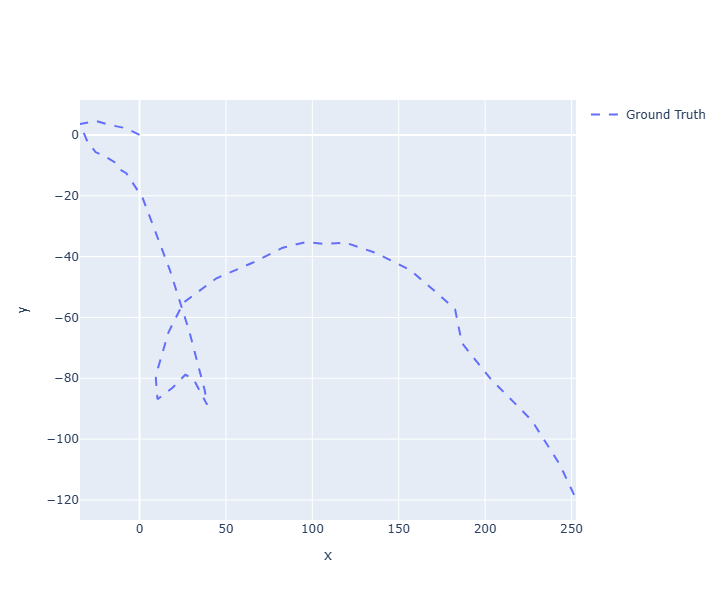

In [160]:
# from stonesoup.plotter import AnimatedPlotterly
# plotter = AnimatedPlotterly(timesteps, tail_length=1.0, width=600, height=600)

from stonesoup.plotter import Plotterly
plotter = Plotterly(autosize=False, width=600, height=600)
plotter.plot_ground_truths(truth, [0, 2])
plotter.fig

## Simulate measurements

Assume a 'linear' sensor which detects the
position, but not velocity, of a target, such that
$\mathbf{z}_k = H_k \mathbf{x}_k + \boldsymbol{\nu}_k$,
$\boldsymbol{\nu}_k \sim \mathcal{N}(0,R)$, with

\begin{align}H_k &= \begin{bmatrix}
                    1 & 0 & 0 & 0\\
                    0  & 0 & 1 & 0\\
                      \end{bmatrix}\\
          R &= \begin{bmatrix}
                  25 & 0\\
                    0 & 25\\
               \end{bmatrix} \omega\end{align}

where $\omega$ is set to 25 initially.

In [161]:
from stonesoup.types.detection import Detection
from stonesoup.models.measurement.linear import LinearGaussian


The linear Gaussian measurement model is set up by indicating the number of dimensions in the
state vector and the dimensions that are measured (so specifying $H_k$) and the noise
covariance matrix $R$.

In [162]:
measurement_model = LinearGaussian(
    ndim_state=4,  # Number of state dimensions (position and velocity in 2D)
    mapping=(0, 2),  # Mapping measurement vector index to state index
    noise_covar=np.array([[16, 0],  # Covariance matrix for Gaussian PDF
                          [0, 16]])
    )

The measurements can now be generated and plotted accordingly.

In [163]:
measurements = []
for state in truth:
    measurement = measurement_model.function(state, noise=True)
    measurements.append(Detection(measurement,
                                  timestamp=state.timestamp,
                                  measurement_model=measurement_model))

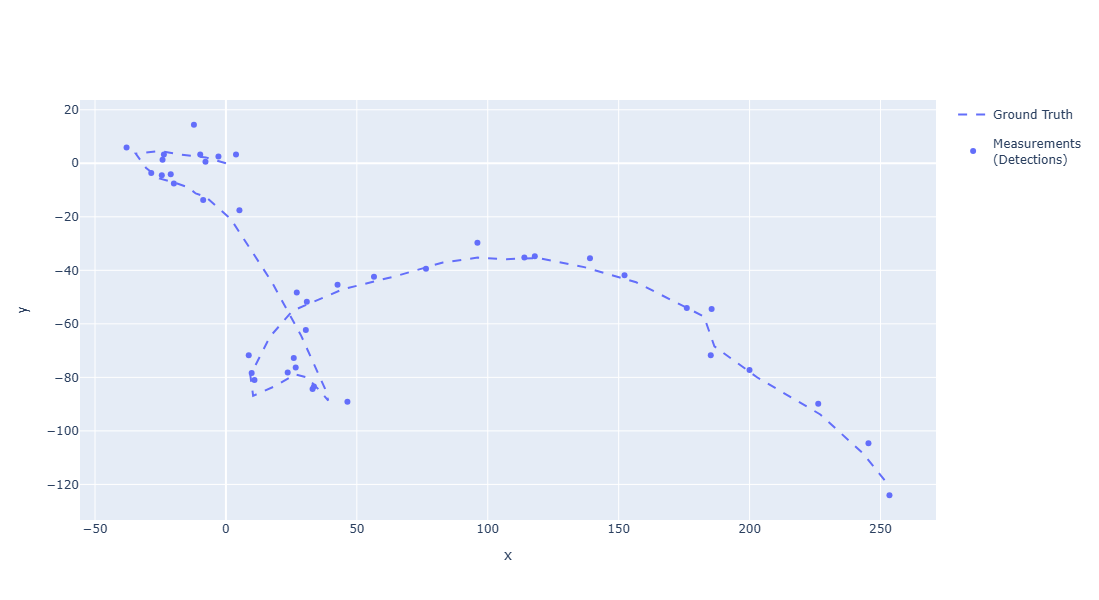

In [164]:
plotter.plot_measurements(measurements, [0, 2])
plotter.fig

## Marginalised Particle Filtering

The `MarginalisedParticlePredictor` and `MarginalisedParticleUpdater` classes correspond to the predict and update steps
respectively.
Both require a `TransitionModel` and a `MeasurementModel` instance respectively.
To avoid degenerate samples, the `SystematicResampler` is used which is passed to the updater.
More resamplers that are included in Stone Soup are covered in the
[Resampler Tutorial](https://stonesoup.readthedocs.io/en/latest/auto_tutorials/sampling/ResamplingTutorial.html#sphx-glr-auto-tutorials-sampling-resamplingtutorial-py).

In [165]:
from stonesoup.predictor.particle import MarginalisedParticlePredictor
from stonesoup.resampler.particle import SystematicResampler
from stonesoup.updater.particle import MarginalisedParticleUpdater

predictor = MarginalisedParticlePredictor(transition_model=transition_model)
resampler = SystematicResampler()
updater = MarginalisedParticleUpdater(measurement_model, resampler)

To start we create a prior estimate. This is a `MarginalisedParticleState` which describes the state as a distribution of particles.

The mean priors are randomly sampled from the standard normal distribution.

The covariance priors is initialised with a scalar multiple of the identity matrix .

In [169]:
from scipy.stats import multivariate_normal
from stonesoup.types.numeric import Probability  # Similar to a float type
from stonesoup.types.state import MarginalisedParticleState
from stonesoup.types.array import StateVectors

number_particles = 100

# Sample from the prior Gaussian distribution
states = multivariate_normal.rvs(np.array([0, 1, 0, 1]),
                                  np.diag([1., 1., 1., 1.]),
                                  size=number_particles)
covars = np.stack([np.eye(4) * 100 for i in range(number_particles)], axis=2) # (M, M, N)

# Create prior particle state.
prior = MarginalisedParticleState(
    state_vector=StateVectors(states.T),
    covariance=covars,
    weight=np.array([Probability(1/number_particles)]*number_particles),
                      timestamp=start_time-timedelta(seconds=1))

We now run the predict and update steps, propagating the collection of particles and resampling at each step

In [ ]:
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

track = Track()
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    hypothesis = SingleHypothesis(prediction, measurement)
    post = updater.update(hypothesis)
    track.append(post)
    prior = track[-1]

Plot the resulting track with the sample points at each iteration. Can also change 'plot_history'
to True if wanted.

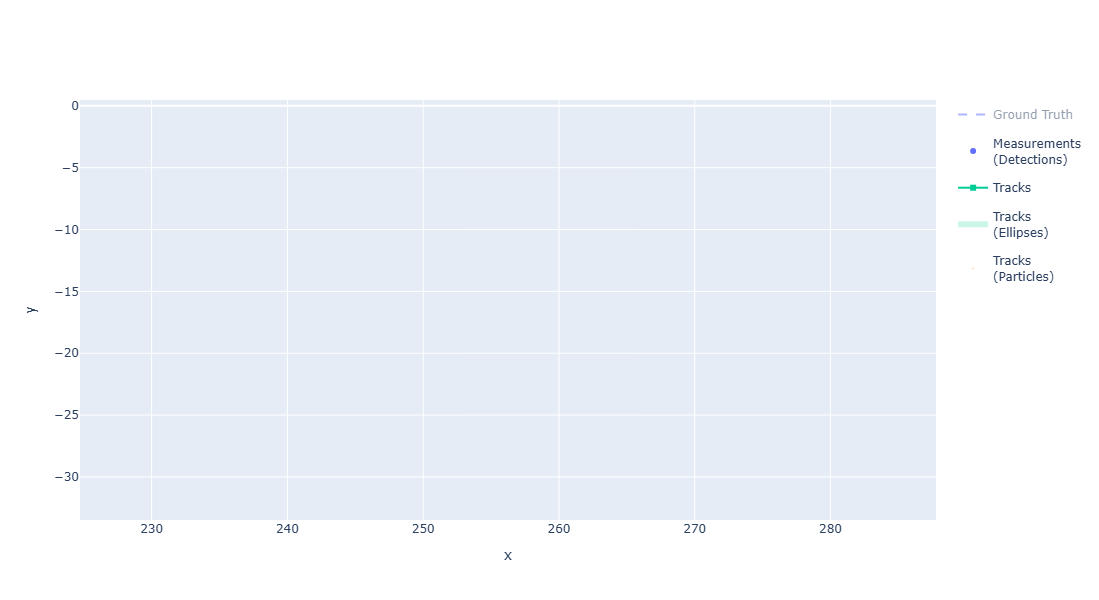

In [132]:
plotter.plot_tracks(track, [0, 2], particle=True, uncertainty=True)
plotter.fig

## References
[1] Lemke, Tatjana, and Simon J. Godsill, 'Inference for models with asymmetric α -stable noise processes', in Siem Jan Koopman, and Neil Shephard (eds), Unobserved Components and Time Series Econometrics (Oxford, 2015; online edn, Oxford Academic, 21 Jan. 2016)

[2] S. Godsill, M. Riabiz, and I. Kontoyiannis, “The L ́evy state space model,” in 2019 53rd Asilomar Conference on Signals, Systems, and Computers, 2019, pp. 487–494.
